<a href="https://colab.research.google.com/github/mastoffel/kingfisher_classifier/blob/main/kingfisher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kingfisher classifier

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install duckduckgo-search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 2.0 MB/s 
     |████████████████████████████████| 96 kB 8.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
import torch 
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from duckduckgo_search import ddg_images
from fastcore.all import *
from pathlib import Path
from PIL import Image
from fastdownload import download_url
from fastai.vision.all import *
from bs4 import BeautifulSoup

# gets urls to images from duckduckgo
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
path = Path('/content/drive/MyDrive/kingfishers')

### download table of river kingfishers from wikipedia page

In [6]:
download_url('https://en.wikipedia.org/wiki/River_kingfisher', 'kingfisher.html', show_progress=False)
# extract table from html
soup = BeautifulSoup(open('kingfisher.html'), 'html.parser')
table = soup.find('table', {'class':'wikitable'})
# extract rows from table
rows = table.find_all('tr')
# extract cells from rows
cells = [r.find_all('td') for r in rows]
# extract text from cells
text = [[c.text for c in r] for r in cells][2:]
# remove newline characters
kingfishers = [t[1].replace('\n', '') for t in text]
# 35 species, scientific names only
len(kingfishers), kingfishers[:5] 

(35,
 ['Ispidina lecontei',
  'Ispidina picta',
  'Corythornis madagascariensis',
  'Corythornis leucogaster',
  'Corythornis cristatus'])

### Download images from duckduckgo

In [ ]:
from time import sleep
for o in kingfishers:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images(o, max_images=10)
    download_images(dest, urls=search_images(f'{o}'), max_pics=10)
    sleep(2)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

KeyboardInterrupt: ignored

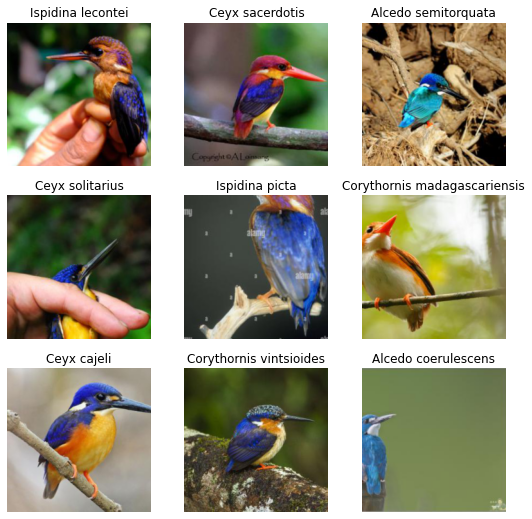

In [8]:
# show example images and labels
dls = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2, item_tfms=Resize(224), bs=32)
dls.show_batch()

### Transforming images and dataset creation

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
image_datasets = {x: ImageFolder(path,data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

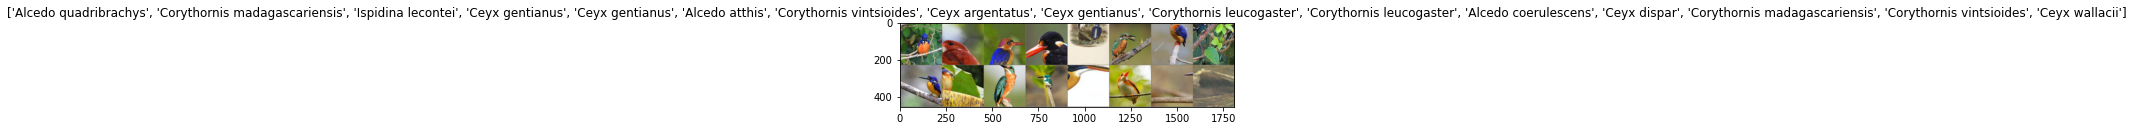

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
model.state_dict()

NameError: ignored

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
# Load pretrained model and reset final fully connected layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 3.4114 Acc: 0.1239
val Loss: 2.7746 Acc: 0.2682

Epoch 1/49
----------
train Loss: 2.7818 Acc: 0.2690
val Loss: 2.0919 Acc: 0.4742

Epoch 2/49
----------
train Loss: 2.3853 Acc: 0.3875
val Loss: 1.7203 Acc: 0.5479

Epoch 3/49
----------
train Loss: 2.1407 Acc: 0.4233
val Loss: 1.4439 Acc: 0.6185

Epoch 4/49
----------
train Loss: 1.9460 Acc: 0.4764
val Loss: 1.3008 Acc: 0.6512

Epoch 5/49
----------
train Loss: 1.8015 Acc: 0.5167
val Loss: 1.1443 Acc: 0.6938

Epoch 6/49
----------
train Loss: 1.6987 Acc: 0.5532
val Loss: 1.0597 Acc: 0.7150

Epoch 7/49
----------
train Loss: 1.5494 Acc: 0.5889
val Loss: 1.0071 Acc: 0.7204

Epoch 8/49
----------
train Loss: 1.5178 Acc: 0.6109
val Loss: 0.9794 Acc: 0.7264

Epoch 9/49
----------
train Loss: 1.5046 Acc: 0.5965
val Loss: 0.9744 Acc: 0.7295

Epoch 10/49
----------
train Loss: 1.5223 Acc: 0.6018
val Loss: 0.9564 Acc: 0.7416

Epoch 11/49
----------
train Loss: 1.5378 Acc: 0.6003
val Loss: 0.9516 Acc: 0.7363

Ep

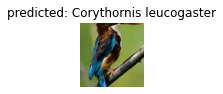

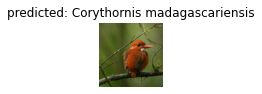

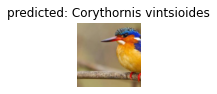

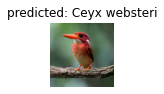

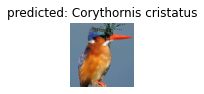

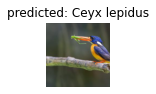

In [25]:
visualize_model(model_ft)

### Training / Validation set and dataloader

In [24]:
# split the dataset into training and validation sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [29]:
# Create a dataloader object for the training and validation sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                            shuffle=True)
valloader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                            shuffle=True)

In [30]:
from torchvision import models

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)

num_classes = len(kingfishers)
# Replace the last fully-connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to training mode
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model and plot train and validation losses
train_losses, val_losses = [], []
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            train_losses.append(running_loss / 10)
            running_loss = 0.0
    # validate the model
    with torch.no_grad():
        val_loss = 0.0
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
print('Finished Training')

[1,    10] loss: 3.689
[1,    20] loss: 3.736
[1,    30] loss: 3.576
[1,    40] loss: 3.606
[1,    50] loss: 3.441
[1,    60] loss: 3.341
[1,    70] loss: 3.277
[1,    80] loss: 3.432
[1,    90] loss: 3.196
[2,    10] loss: 2.731
[2,    20] loss: 2.754
[2,    30] loss: 2.781
[2,    40] loss: 2.893
[2,    50] loss: 2.694
[2,    60] loss: 2.808
[2,    70] loss: 2.676
[2,    80] loss: 2.389
[2,    90] loss: 2.630
[3,    10] loss: 1.922
[3,    20] loss: 2.382
[3,    30] loss: 2.026
[3,    40] loss: 1.956
[3,    50] loss: 1.907
[3,    60] loss: 1.991
[3,    70] loss: 2.293
[3,    80] loss: 2.051
[3,    90] loss: 2.221
[4,    10] loss: 1.631
[4,    20] loss: 1.830
[4,    30] loss: 1.893
[4,    40] loss: 1.620
[4,    50] loss: 1.543
[4,    60] loss: 1.683
[4,    70] loss: 1.774
[4,    80] loss: 1.995
[4,    90] loss: 1.666
[5,    10] loss: 1.369
[5,    20] loss: 1.598
[5,    30] loss: 1.357
[5,    40] loss: 1.379
[5,    50] loss: 1.394
[5,    60] loss: 1.466
[5,    70] loss: 1.643
[5,    80] 

In [ ]:
# use the trained model to make predictions
# get a batch of validation images
from matplotlib.pyplot import imshow
dataiter = iter(valloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
# print images
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % kingfishers[labels[j]] for j in range(4)))
# make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % kingfishers[predicted[j]]
                                for j in range(4)))


GroundTruth:  Corythornis leucogaster Corythornis leucogaster Corythornis leucogaster Corythornis madagascariensis
Predicted:  Corythornis leucogaster Corythornis leucogaster Alcedo coerulescens Ispidina picta
